# Importing Libraries

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Model Initialization

In [2]:
def is_palindrome(binary_str):
    return binary_str == binary_str[::-1]

In [3]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size, momentum_factor, seed=None):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.momentum_factor = momentum_factor

        # Initialize weights and biases
        np.random.seed(seed)

        #### Xavier/Glorot Initialization (Preferred For Sigmoid)
        self.weights_input_hidden = np.random.normal(0, np.sqrt(2. / self.input_size), (self.input_size, self.hidden_size))
        self.bias_input_hidden = np.zeros((1, self.hidden_size))
        self.weights_hidden_output = np.random.normal(0, np.sqrt(2. / self.hidden_size), (self.hidden_size, self.output_size))
        self.bias_hidden_output = np.zeros((1, self.output_size))

        self.momentum_weights_input_hidden = np.zeros_like(self.weights_input_hidden)
        self.momentum_bias_input_hidden = np.zeros_like(self.bias_input_hidden)
        self.momentum_weights_hidden_output = np.zeros_like(self.weights_hidden_output)
        self.momentum_bias_hidden_output = np.zeros_like(self.bias_hidden_output)


    def reLu(self, x):
        return np.maximum(0,x)

    def reLu_derivative(self,x):
        x[x<=0] = 0
        x[x>0] = 1
        return x

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1-x)

    def forward_propagation(self, X):
        self.hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        self.hidden_output = self.sigmoid(self.hidden_input)

        self.output_input = np.dot(self.hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        self.output = self.sigmoid(self.output_input)


    def backward_propagation(self, X, y):
        output_error = y - self.output # TSS Loss
        output_delta = output_error * self.sigmoid_derivative(self.output) # del(j)

        hidden_error = output_delta.dot(self.weights_hidden_output.T) # del(j)*wjk
        hidden_delta = hidden_error * self.sigmoid_derivative(self.hidden_output)

        return output_delta, hidden_delta

    def update_parameters(self, X, output_delta, hidden_delta, learning_rate):
        #Delta For OuterMost Layer-----------> del(E)/del(netK)
        self.momentum_weights_hidden_output = self.momentum_factor * self.momentum_weights_hidden_output + (1-self.momentum_factor) * self.hidden_output.T.dot(output_delta)
        self.momentum_bias_hidden_output = self.momentum_factor * self.momentum_bias_hidden_output + (1-self.momentum_factor)* np.sum(output_delta, axis=0, keepdims=True)

        #Delta For Hidden Layyer-------------> del(E)/del(netj) ---> Sum of next layer(weights*delta)*derivative of activation
        self.momentum_weights_input_hidden = self.momentum_factor * self.momentum_weights_input_hidden + (1-self.momentum_factor)* X.T.dot(hidden_delta)
        self.momentum_bias_input_hidden = self.momentum_factor * self.momentum_bias_input_hidden + (1-self.momentum_factor)* np.sum(hidden_delta, axis=0, keepdims=True)


        self.weights_hidden_output += self.momentum_weights_hidden_output*learning_rate
        self.bias_hidden_output += self.momentum_bias_hidden_output*learning_rate
        self.weights_input_hidden += self.momentum_weights_input_hidden*learning_rate
        self.bias_input_hidden += self.momentum_bias_input_hidden*learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            self.forward_propagation(X)

            output_delta, hidden_delta = self.backward_propagation(X, y)

            self.update_parameters(X, output_delta, hidden_delta, learning_rate)

    def predict(self, X):
        self.forward_propagation(X)
        predictions = (self.output > 0.5).astype(int)
        return predictions

    def get_neuron_predict(self, X):
        hidden_input = np.dot(X, self.weights_input_hidden) + self.bias_input_hidden
        hidden_output = self.sigmoid(hidden_input)
        output_input = np.dot(hidden_output, self.weights_hidden_output) + self.bias_hidden_output
        output = self.sigmoid(output_input)
        return (hidden_input, hidden_output,output_input,output)

    # To save the model
    def save_model(self, filename='model.pkl'):
        model_state = {
            'input_size': self.input_size,
            'hidden_size': self.hidden_size,
            'output_size': self.output_size,
            'momentum_factor': self.momentum_factor,
            'weights_input_hidden': self.weights_input_hidden,
            'bias_input_hidden': self.bias_input_hidden,
            'weights_hidden_output': self.weights_hidden_output,
            'bias_hidden_output': self.bias_hidden_output,
            'momentum_weights_input_hidden': self.momentum_weights_input_hidden,
            'momentum_bias_input_hidden': self.momentum_bias_input_hidden,
            'momentum_weights_hidden_output': self.momentum_weights_hidden_output,
            'momentum_bias_hidden_output': self.momentum_bias_hidden_output,
        }

        with open(filename, 'wb') as file:
            pickle.dump(model_state, file)
        print(f"Model parameters saved to {filename}")

    # To Load the Model
    def load_model(self, filename='model.pkl'):
        with open(filename, 'rb') as file:
            model_state = pickle.load(file)

        # Update the current instance's parameters with loaded values
        self.input_size = model_state['input_size']
        self.hidden_size = model_state['hidden_size']
        self.output_size = model_state['output_size']
        self.momentum_factor = model_state['momentum_factor']
        self.weights_input_hidden = model_state['weights_input_hidden']
        self.bias_input_hidden = model_state['bias_input_hidden']
        self.weights_hidden_output = model_state['weights_hidden_output']
        self.bias_hidden_output = model_state['bias_hidden_output']
        self.momentum_weights_input_hidden = model_state['momentum_weights_input_hidden']
        self.momentum_bias_input_hidden = model_state['momentum_bias_input_hidden']
        self.momentum_weights_hidden_output = model_state['momentum_weights_hidden_output']
        self.momentum_bias_hidden_output = model_state['momentum_bias_hidden_output']

        print(f"Model parameters loaded from {filename}")


    def train_and_evaluate(self,X, y, input_size, hidden_size, output_size, epochs, learning_rate,k_folds=5, seed=None):
        kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

        precisions = []
        f1_scores = []
        recalls = []
        for train_index, test_index in kf.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            self.train(X_train, y_train, epochs, learning_rate)

            predictions = self.predict(X_test)
            precision = precision_score(y_test, predictions)
            f1_scr = f1_score(y_test, predictions)
            recall = recall_score(y_test, predictions)
            precisions.append(precision)
            f1_scores.append(f1_scr)
            recalls.append(recall)

            print(f'Precision: {precision}, F1-score: {f1_scr}, Recall: {recall}')
            # print(y_test.flatten())
            # print(predictions.flatten())

        avg_precision = np.mean(precisions)
        avg_f1_score = np.mean(f1_scores)
        avg_recall = np.mean(recalls)
        self.save_model()
        print(f'Average Precision across {k_folds} folds: {avg_precision}\nAverage F1-score across {k_folds} folds: {avg_f1_score}\nAverage Recall across {k_folds} folds: {avg_recall}')

# Model Instantiation

In [4]:
# Example usage
input_size = 10
hidden_size = 2
output_size = 1
momentum_factor = 0.3

# Loading Data

In [5]:
all_binary_strings = [format(i, '010b') for i in range(2**10)]
inputs = np.array([list(map(int, binary_str)) for binary_str in all_binary_strings], dtype=np.int16)
targets = np.array([is_palindrome(binary_str) for binary_str in all_binary_strings], dtype=np.int16).reshape(-1, 1)

non_palindrome_indices = np.where(targets[:, 0] == 0)[0]
palindrome_indices = np.where(targets[:, 0] == 1)[0]
np.random.shuffle(non_palindrome_indices)
balanced_indices = np.concatenate([non_palindrome_indices[:len(palindrome_indices)], palindrome_indices])
np.random.shuffle(balanced_indices)
#print(balanced_indices)
oversample_indicies = np.append(balanced_indices,balanced_indices)

balanced_inputs = inputs[oversample_indicies]
balanced_targets = targets[oversample_indicies]
smote = SMOTE()
inputs_resampled, targets_resampled = smote.fit_resample(inputs, targets)
targets_resampled = targets_resampled.reshape(-1, 1)
# Create neural network
neural_network = NeuralNetwork(input_size, hidden_size, output_size,momentum_factor=momentum_factor)
#neural_network.train_and_evaluate(inputs_resampled,targets_resampled,input_size,hidden_size,output_size,10000,0.01,5,seed=52)


## Loading Saved Model

In [6]:
neural_network.load_model("model.pkl") #loading the trained model.

Model parameters loaded from model.pkl


# Testing

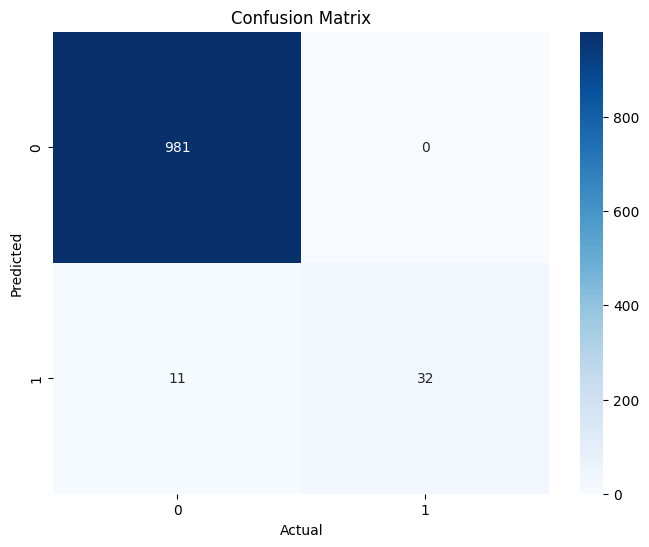

In [7]:
y_predict = neural_network.predict(inputs)
cm = confusion_matrix(y_predict, targets)
# Plotting the confusion matrix using Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [8]:
print(neural_network.weights_input_hidden.T)
print(neural_network.weights_hidden_output.T)
print(neural_network.bias_hidden_output)
print(neural_network.bias_input_hidden)

[[-21.103238  -5.229046 -10.497463  13.877196   7.25821   -7.217289
  -13.849237  10.503724   5.2652    21.084626]
 [ 21.406045   5.327159  10.700617 -12.693136  -7.357754   7.38126
   12.728184 -10.644741  -5.290742 -21.352189]]
[[-30.577723 -30.204053]]
[[14.855507]]
[[-1.663453 -1.72729 ]]


In [9]:
#np.set_printoptions(suppress=True, formatter={'float': lambda x: "{:+.6f}".format(x)})

In [10]:
neural_network.get_neuron_predict([1,1,1,1,1,1,1,1,1,1])

[[-1.57077  -1.522587]]


(array([[-1.57077 , -1.522587]]),
 array([[0.17210665, 0.17908089]]),
 array([[4.18390895]]),
 array([[0.98498991]]))

In [11]:
neural_network.get_neuron_predict([1,0,1,1,1,1,1,1,0,1])

[[-1.606924 -1.559004]]


(array([[-1.606924, -1.559004]]),
 array([[0.16701611, 0.17378961]]),
 array([[4.49938385]]),
 array([[0.98900636]]))

In [12]:
neural_network.get_neuron_predict([0,1,1,1,1,1,1,1,1,1])

[[ 19.532468 -22.928632]]


(array([[ 19.532468, -22.928632]]),
 array([[9.99999997e-01, 1.10210163e-10]]),
 array([[-15.7222159]]),
 array([[1.48569043e-07]]))

In [13]:
print(neural_network.sigmoid(+19.532468))
print(neural_network.sigmoid(-22.928632))

0.9999999967102953
1.1021016301337228e-10


In [14]:
x1,x2,x3, x4 = neural_network.get_neuron_predict([0,1,1,0,1,1,1,1,1,1])
print(x1)
print(x2)
print(x3)
print(x4)

[[  5.655272 -10.235496]]
[[  5.655272 -10.235496]]
[[9.96513179e-01 3.58727762e-05]]
[[-15.61668046]]
[[1.6510559e-07]]


In [15]:
neural_network.get_neuron_predict([0,0,0,0,0,0,0,0,0,0])

[[-1.663453 -1.72729 ]]


(array([[-1.663453, -1.72729 ]]),
 array([[0.15929902, 0.15093455]]),
 array([[5.42567073]]),
 array([[0.99561718]]))

In [16]:
neural_network.get_neuron_predict([1,1,1,1,1,0,0,0,0,0])

[[-17.357794  15.655641]]


(array([[-17.357794,  15.655641]]),
 array([[2.89471516e-08, 9.99999841e-01]]),
 array([[-15.34854209]]),
 array([[2.1588018e-07]]))

In [17]:
neural_network.get_neuron_predict([0,0,0,0,0,1,1,1,1,1])

[[ 14.123571 -18.905518]]


(array([[ 14.123571, -18.905518]]),
 array([[9.99999265e-01, 6.15797402e-09]]),
 array([[-15.72219372]]),
 array([[1.48572339e-07]]))

In [18]:
neural_network.get_neuron_predict([1,0,0,0,0,0,0,0,0,1])

[[-1.682065 -1.673434]]


(array([[-1.682065, -1.673434]]),
 array([[0.15682222, 0.15796687]]),
 array([[5.28900068]]),
 array([[0.99497854]]))

In [19]:
neural_network.get_neuron_predict([0,0,0,0,0,0,1,1,0,0])

[[-5.008966  0.356153]]


(array([[-5.008966,  0.356153]]),
 array([[0.00663351, 0.58810887]]),
 array([[-3.1106019]]),
 array([[0.04267205]]))

In [20]:
neural_network.get_neuron_predict([0,0,0,0,1,1,0,0,0,0])

[[-1.622532 -1.703784]]


(array([[-1.622532, -1.703784]]),
 array([[0.16485597, 0.1539717 ]]),
 array([[5.16401739]]),
 array([[0.99431384]]))

In [21]:
neural_network.get_neuron_predict([0,0,1,1,0,0,0,0,0,0])

[[ 1.71628  -3.719809]]


(array([[ 1.71628 , -3.719809]]),
 array([[0.84764906, 0.02366499]]),
 array([[-11.77844967]]),
 array([[7.66797999e-06]]))

In [22]:
neural_network.get_neuron_predict([1,1,0,0,0,0,0,0,0,0])

[[-27.995737  25.005914]]


(array([[-27.995737,  25.005914]]),
 array([[6.94393911e-13, 1.00000000e+00]]),
 array([[-15.348546]]),
 array([[2.15879336e-07]]))

In [23]:
neural_network.get_neuron_predict([1,1,1,1,1,1,1,1,1,0])

[[-22.655396  19.829602]]


(array([[-22.655396,  19.829602]]),
 array([[1.44839338e-10, 9.99999998e-01]]),
 array([[-15.34854593]]),
 array([[2.15879351e-07]]))

# Evaluation

In [34]:
def check_10_bit_input(bit_list):
    if len(bit_list) != 10:
        return False  # Length should be strictly 10
    for bit in bit_list:
        if bit not in {0, 1}:
            return False  # Should contain only 0s and 1s
    return True

while True:
    user_input = input("Enter a 10-bit binary number: ")
    bit_list=[int(bit) for bit in user_input]
    if check_10_bit_input(bit_list):
        if neural_network.predict(bit_list)[0][0] > 0.5 :
          print("Palindrome")
        else :
          print("Not Palindrome")
    else:
        print("Invalid input. Please enter a 10-bit binary number containing only 0s and 1s. Try again.")

Enter a 10-bit binary number: 0101010101
Not Palindrome
Enter a 10-bit binary number: 1234567890
Invalid input. Please enter a 10-bit binary number containing only 0s and 1s. Try again.
Enter a 10-bit binary number: 0110010000
Not Palindrome
Enter a 10-bit binary number: 1111111111
Palindrome
Enter a 10-bit binary number: 1010101010
Not Palindrome
Enter a 10-bit binary number: 1100000011
Palindrome


KeyboardInterrupt: Interrupted by user